# **Projeto kmeans - Modelo LMM Gemma**

In [32]:
# Importando bibliotecas

# bibliotecas sistema
import re
import string
import collections
from collections import Counter

# Biblioteca para manipulação dados
import pandas as pd
import numpy as np

# Biblioteca visualização de dados
import matplotlib.pyplot as plt
import seaborn as sns

# Biblioteca NLP
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Biblioteca mensagens de alertas
import warnings
warnings.filterwarnings('ignore')

# Biblioteca para modelos LLM
import torch
import gemma
import keras_nlp
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.models import Model

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rafae\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rafae\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\rafae\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [33]:
# Versão GPU
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Mon_Apr__3_17:36:15_Pacific_Daylight_Time_2023
Cuda compilation tools, release 12.1, V12.1.105
Build cuda_12.1.r12.1/compiler.32688072_0


In [34]:
# Versão keras tensorflow
import keras
import tensorflow as tf
print("Versão tensorflow:", tf.__version__)
print("Versão keras:", keras.__version__)

Versão tensorflow: 2.17.0-dev20240412
Versão keras: 3.2.1


In [35]:
# Tipo GPU
!nvidia-smi

Sat Apr 13 13:28:48 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 551.86                 Driver Version: 551.86         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050 ...  WDDM  |   00000000:01:00.0  On |                  N/A |
| N/A   53C    P8              8W /   80W |     286MiB /   4096MiB |     25%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [36]:
# Verifique se a GPU está disponível
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Dispositivo disponível:", device)

Dispositivo disponível: cpu


In [37]:
# Base dados
df = pd.read_csv('Tweets.csv')
df

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative
...,...,...,...,...
27476,4eac33d1c0,wish we could come see u on Denver husband l...,d lost,negative
27477,4f4c4fc327,I`ve wondered about rake to. The client has ...,", don`t force",negative
27478,f67aae2310,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,positive
27479,ed167662a5,But it was worth it ****.,But it was worth it ****.,positive


In [38]:
# Visualizando 5 primeiros dados
df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [39]:
# Visualizando 5 últimos dados
df.tail()

,textID,text,selected_text,sentiment
27476,4eac33d1c0,wish we could come see u on Denver husband l...,d lost,negative
27477,4f4c4fc327,I`ve wondered about rake to. The client has ...,", don`t force",negative
27478,f67aae2310,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,positive
27479,ed167662a5,But it was worth it ****.,But it was worth it ****.,positive
27480,6f7127d9d7,All this flirting going on - The ATG smiles...,All this flirting going on - The ATG smiles. Y...,neutral


In [40]:
# Visualziando linhas e colunas
df.shape

(27481, 4)

In [41]:
# Info dados
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


In [42]:
# Tipo de dados
df.dtypes

textID           object
text             object
selected_text    object
sentiment        object
dtype: object

## **Pré-processamento**

In [43]:
# Converter todos os valores da coluna "clean_text" para strings
df['text'] = df['text'].astype(str)

In [44]:
# Converter todos os valores da coluna "clean_text" para strings
df['selected_text'] = df['selected_text'].astype(str)

In [45]:
# Converter todos os valores da coluna "clean_text" para strings
df['sentiment'] = df['sentiment'].astype(str)

In [46]:
# Excluir coluna
df = df.drop(['textID'], axis=1)
df.head()

,text,selected_text,sentiment
0,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,my boss is bullying me...,bullying me,negative
3,what interview! leave me alone,leave me alone,negative
4,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [47]:
# Função para pré-processamento do texto
def preprocess_text(text):
    if isinstance(text, str):

        # Verificar se o texto é uma string
        # Converter texto para minúsculas
        text = text.lower()

        # Remover emojis
        emoji_pattern = re.compile("["
                                   u"\U0001F600-\U0001F64F"  # emoticons
                                   u"\U0001F300-\U0001F5FF"  # símbolos & pictogramas
                                   u"\U0001F680-\U0001F6FF"  # transporte & símbolos mapas
                                   u"\U0001F1E0-\U0001F1FF"  # bandeiras (iOS)
                                   u"\U00002500-\U00002BEF"  # caracteres chineses/japoneses coreanos unificados
                                   u"\U00002702-\U000027B0"
                                   u"\U00002702-\U000027B0"
                                   u"\U000024C2-\U0001F251"
                                   u"\U0001f926-\U0001f937"
                                   u"\U00010000-\U0010ffff"
                                   u"\u2640-\u2642"
                                   u"\u2600-\u2B55"
                                   u"\u200d"
                                   u"\u23cf"
                                   u"\u23e9"
                                   u"\u231a"
                                   u"\ufe0f"  # dingbats
                                   u"\u3030"
                                   "]+", flags=re.UNICODE)
        text = emoji_pattern.sub(r'', text)

        # Remover caracteres especiais
        text = re.sub(r'[^\w\s]', '', text)

        # Tokenizar o texto em palavras
        tokens = word_tokenize(text)

        # Remover stopwords
        stop_words = set(stopwords.words('english')) # Defina o idioma apropriado
        tokens = [word for word in tokens if word not in stop_words]

        # Lematização (redução das palavras às suas formas base)
        lemmatizer = WordNetLemmatizer() # Utilize o lematizador apropriado para o idioma
        tokens = [lemmatizer.lemmatize(word) for word in tokens]

        # Juntar as palavras de volta em texto
        preprocessed_text = ' '.join(tokens)
    else:
        preprocessed_text = np.nan  # Caso não seja uma string, mantenha o valor como NaN

    return preprocessed_text

# Aplicar a função de pré-processamento à coluna "clean_text"
df['clean_text_2'] = df['text'].apply(preprocess_text)

In [48]:
# Remover linhas com valores nulos na coluna 'clean_text_2'
df = df.dropna(subset=['clean_text_2'])

In [49]:
# Converter todos os valores da coluna "clean_text" para strings
df['clean_text_2'] = df['clean_text_2'].astype(str)

In [50]:
# Concatenar todos os textos em uma única string
all_text = ' '.join(df['clean_text_2'])

In [51]:
# Exibir o DataFrame resultante
df.head()

,text,selected_text,sentiment,clean_text_2
0,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,id responded going
1,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,sooo sad miss san diego
2,my boss is bullying me...,bullying me,negative,bos bullying
3,what interview! leave me alone,leave me alone,negative,interview leave alone
4,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,son couldnt put release already bought


# **Análise sentimentos**

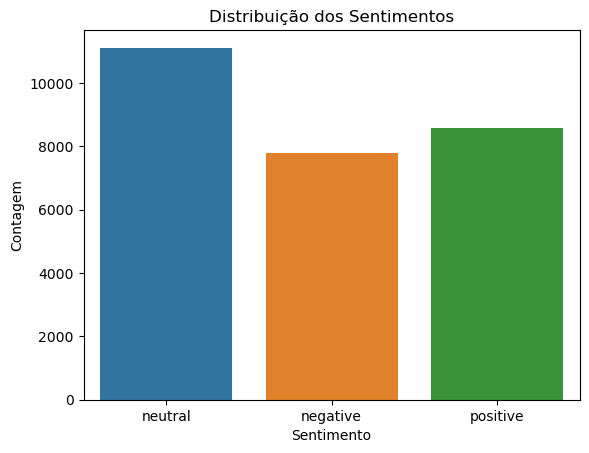

In [52]:
# Gráfico barra
sns.countplot(x='sentiment', data=df)
plt.title('Distribuição dos Sentimentos')
plt.xlabel('Sentimento')
plt.ylabel('Contagem')
plt.show()

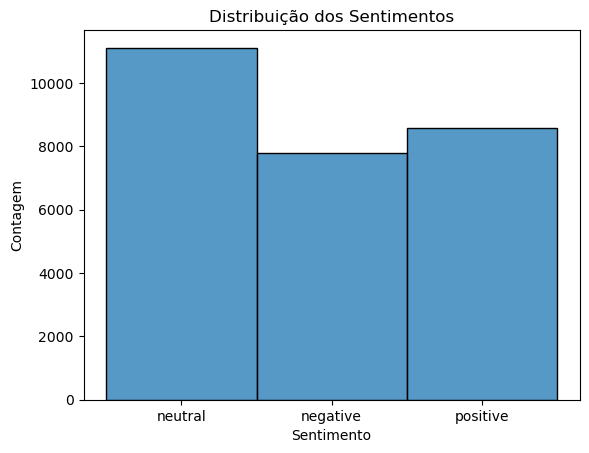

In [53]:
sns.histplot(df['sentiment'])
plt.title('Distribuição dos Sentimentos')
plt.xlabel('Sentimento')
plt.ylabel('Contagem')
plt.show()

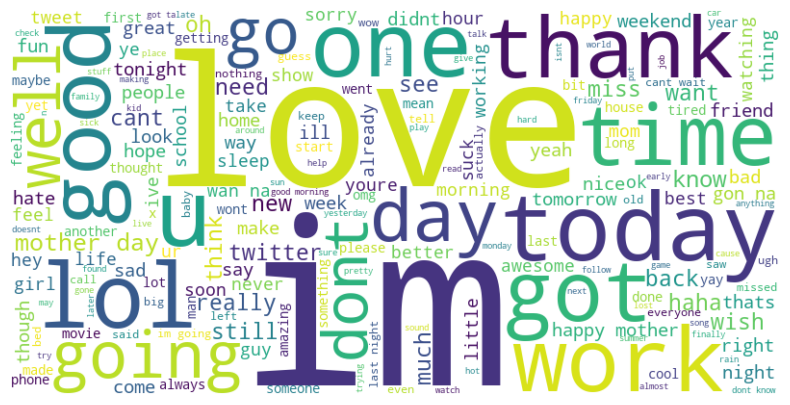

In [54]:
## Gráfico nuvem palavras

# Importando biblioteca
from wordcloud import WordCloud

# Criar a nuvem de palavras
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

# Plotar a nuvem de palavras
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [55]:
# Tokenização dos textos
tokenized_texts = df["clean_text_2"].apply(lambda x: word_tokenize(x))

# Contagem de tokens
all_tokens = [token for sublist in tokenized_texts for token in sublist]
token_counts = nltk.FreqDist(all_tokens)

# Ordenar os tokens do maior para o menor
sorted_token_counts = dict(sorted(token_counts.items(), key=lambda item: item[1], reverse=True))

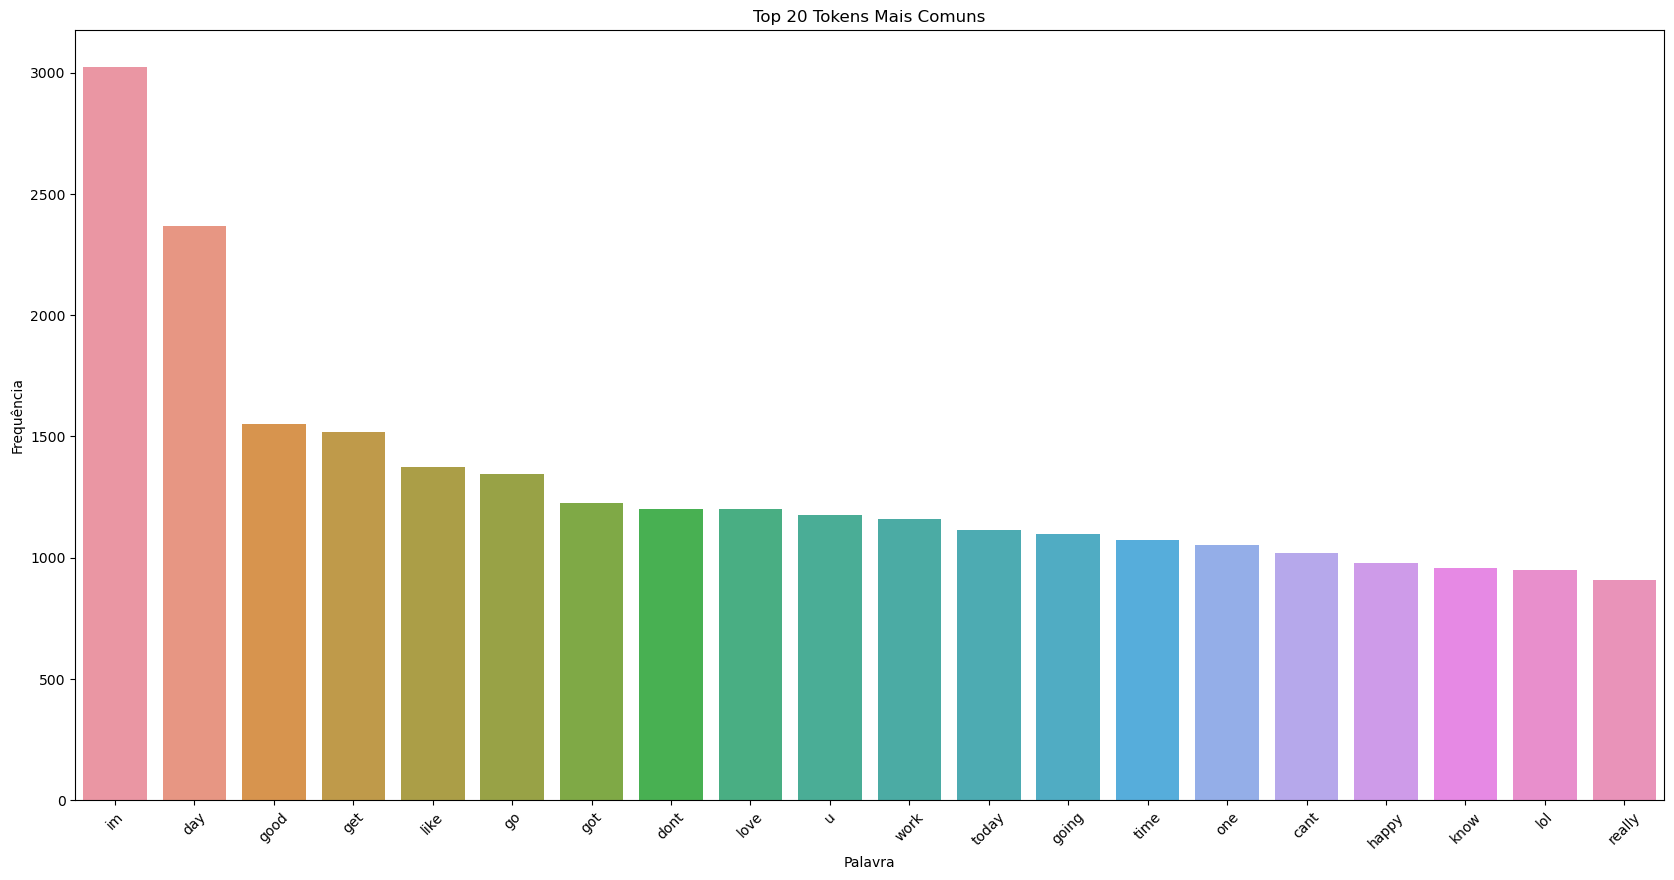

In [56]:
# Plotar o gráfico de barras para os top 20 tokens mais comuns
plt.figure(figsize=(20.5, 10))
plt.title('Top 20 Tokens Mais Comuns')
plt.xlabel('Palavra')
plt.ylabel('Frequência')
sns.barplot(x=list(sorted_token_counts.keys())[:20], y=list(sorted_token_counts.values())[:20])
plt.xticks(rotation=45)
plt.show()

In [57]:
# Extração ngrams
from nltk.util import ngrams
from nltk.tokenize import word_tokenize

# Definir o valor de N para os N-grams
# Defina o valor de N conforme necessário para extrair N-grams de 2 palavras
N = 2

# Função para extrair N-grams de um texto
def extract_ngrams(text):
    tokens = word_tokenize(str(text))  # Tokenizar o texto
    n_grams = list(ngrams(tokens, N))  # Extrair N-grams
    return n_grams

# Aplicar a função extract_ngrams à coluna clean_text_2
df['ngrams'] = df['clean_text_2'].apply(extract_ngrams)

# Aplicar a função extract_and_count_ngrams à coluna clean_text_2 e contar a ocorrência de cada N-gram
all_ngrams = [ngram for sublist in df['ngrams'] for ngram in sublist]
ngram_counts = Counter(all_ngrams)

# Visualizando
df.head()

,text,selected_text,sentiment,clean_text_2,ngrams
0,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,id responded going,"[(id, responded), (responded, going)]"
1,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,sooo sad miss san diego,"[(sooo, sad), (sad, miss), (miss, san), (san, ..."
2,my boss is bullying me...,bullying me,negative,bos bullying,"[(bos, bullying)]"
3,what interview! leave me alone,leave me alone,negative,interview leave alone,"[(interview, leave), (leave, alone)]"
4,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,son couldnt put release already bought,"[(son, couldnt), (couldnt, put), (put, release..."


In [58]:
# Obter os N-grams mais comuns
top_ngrams = ngram_counts.most_common(20)

# Extrair os N-grams e suas contagens
ngram_labels = [' '.join(ngram[0]) for ngram in top_ngrams]
ngram_freqs = [ngram[1] for ngram in top_ngrams]

In [59]:
# Criar um DataFrame para plotar com Seaborn
data = pd.DataFrame({'N-gram': ngram_labels, 'Frequência': ngram_freqs})
data.head()

,N-gram,Frequência
0,mother day,627
1,happy mother,464
2,gon na,433
3,wan na,249
4,im going,186


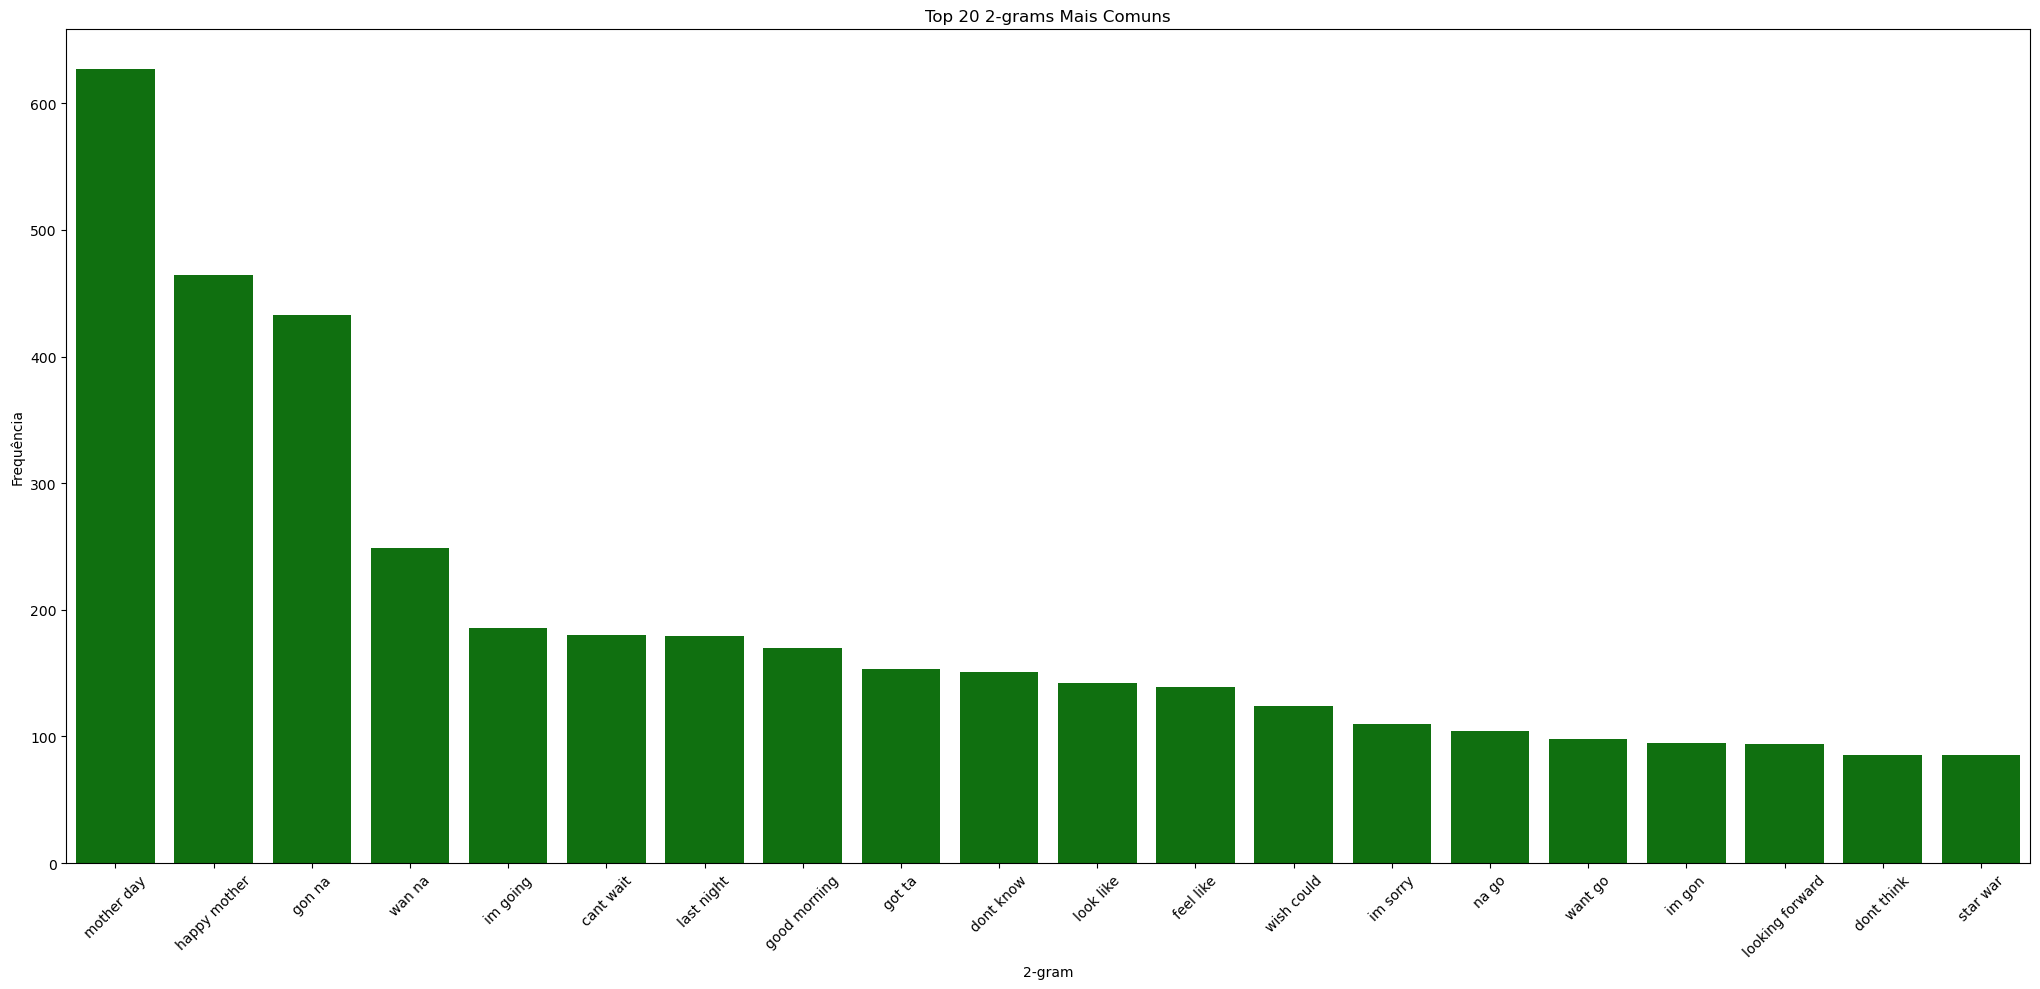

In [60]:
# Plotar o gráfico de barras com Seaborn
plt.figure(figsize=(20.5, 10))
sns.barplot(x='N-gram', y='Frequência', data=data, color="green")
plt.title(f'Top 20 {N}-grams Mais Comuns')
plt.xlabel(f'{N}-gram')
plt.ylabel('Frequência')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [61]:
# Divisão dados
x = df['clean_text_2']
y = df['sentiment']

In [62]:
# Vetorização dados
from sklearn.feature_extraction.text import TfidfVectorizer

# Pré-processamento dos dados
vectorizer = TfidfVectorizer()

# Treinamento modelo
X = vectorizer.fit_transform(x)

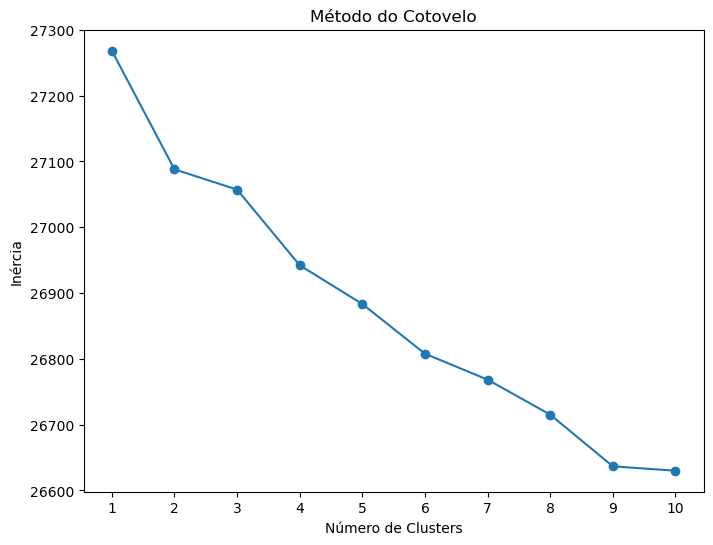

In [63]:
# Importando biblioteca
from sklearn.cluster import KMeans

# Calcular a inércia para diferentes números de clusters
inertia_values = []

# Testando de 1 a 10 clusters
for num_clusters in range(1, 11):
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(X)
    inertia_values.append(kmeans.inertia_)

# Plotar o gráfico do método do cotovelo
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), inertia_values, marker='o', linestyle='-')
plt.title('Método do Cotovelo')
plt.xlabel('Número de Clusters')
plt.ylabel('Inércia')
plt.xticks(range(1, 11))
plt.grid(False)
plt.show()

# **Modelo Kmeans**

In [64]:
%%time

# Modelo kmeans

# Defina o número de clusters
num_clusters = 5

# Modelo
kmeans = KMeans(n_clusters=num_clusters)

# Treinamento modelo
kmeans.fit(X)

CPU times: total: 8.72 s
Wall time: 3.84 s


KMeans(n_clusters=5)

In [65]:
# Obter os rótulos dos clusters para cada texto
labels = kmeans.labels_

In [66]:
# Adicionar os rótulos dos clusters ao DataFrame
df['cluster'] = labels

In [67]:
# Imprimir os rótulos dos clusters e o número de clusters únicos
print("Rótulos dos Clusters:", kmeans.labels_)
print("Número de Clusters Únicos:", num_clusters)

Rótulos dos Clusters: [0 0 0 ... 3 0 0]
Número de Clusters Únicos: 5


In [68]:
from sklearn.metrics import silhouette_score

# Avaliação da qualidade da clusterização
num_clusters = len(np.unique(kmeans.labels_))
if num_clusters > 1:
    silhouette_avg = silhouette_score(X, kmeans.labels_)
    print("Silhouette Score:", silhouette_avg)
else:
    print("Não é possível calcular o escore de silhueta com apenas um cluster.")

Silhouette Score: 0.00517906402270777


In [74]:
%%time

# Importando biblioteca
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD

# Reduzir a dimensionalidade dos vetores de características usando o TruncatedSVD
tsne = TruncatedSVD(n_components=2)
X_tsne_Truncated_SVD = tsne.fit_transform(X)

# Reduzir a dimensionalidade dos vetores de características usando o PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray())

# Reduzir a dimensionalidade dos vetores de características usando o t-SNE
tsne = TSNE(n_components=2, perplexity=200)
X_tsne = tsne.fit_transform(X.toarray())

CPU times: total: 54min 11s
Wall time: 9min 45s


In [75]:
# Adicionar os rótulos dos clusters e os sentimentos ao DataFrame
df['cluster'] = kmeans.labels_
df

,text,selected_text,sentiment,clean_text_2,ngrams,cluster
0,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,id responded going,"[(id, responded), (responded, going)]",0
1,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,sooo sad miss san diego,"[(sooo, sad), (sad, miss), (miss, san), (san, ...",0
2,my boss is bullying me...,bullying me,negative,bos bullying,"[(bos, bullying)]",0
3,what interview! leave me alone,leave me alone,negative,interview leave alone,"[(interview, leave), (leave, alone)]",0
4,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,son couldnt put release already bought,"[(son, couldnt), (couldnt, put), (put, release...",0
...,...,...,...,...,...,...
27476,wish we could come see u on Denver husband l...,d lost,negative,wish could come see u denver husband lost job ...,"[(wish, could), (could, come), (come, see), (s...",0
27477,I`ve wondered about rake to. The client has ...,", don`t force",negative,ive wondered rake client made clear net dont f...,"[(ive, wondered), (wondered, rake), (rake, cli...",0
27478,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,positive,yay good enjoy break probably need hectic week...,"[(yay, good), (good, enjoy), (enjoy, break), (...",3
27479,But it was worth it ****.,But it was worth it ****.,positive,worth,[],0


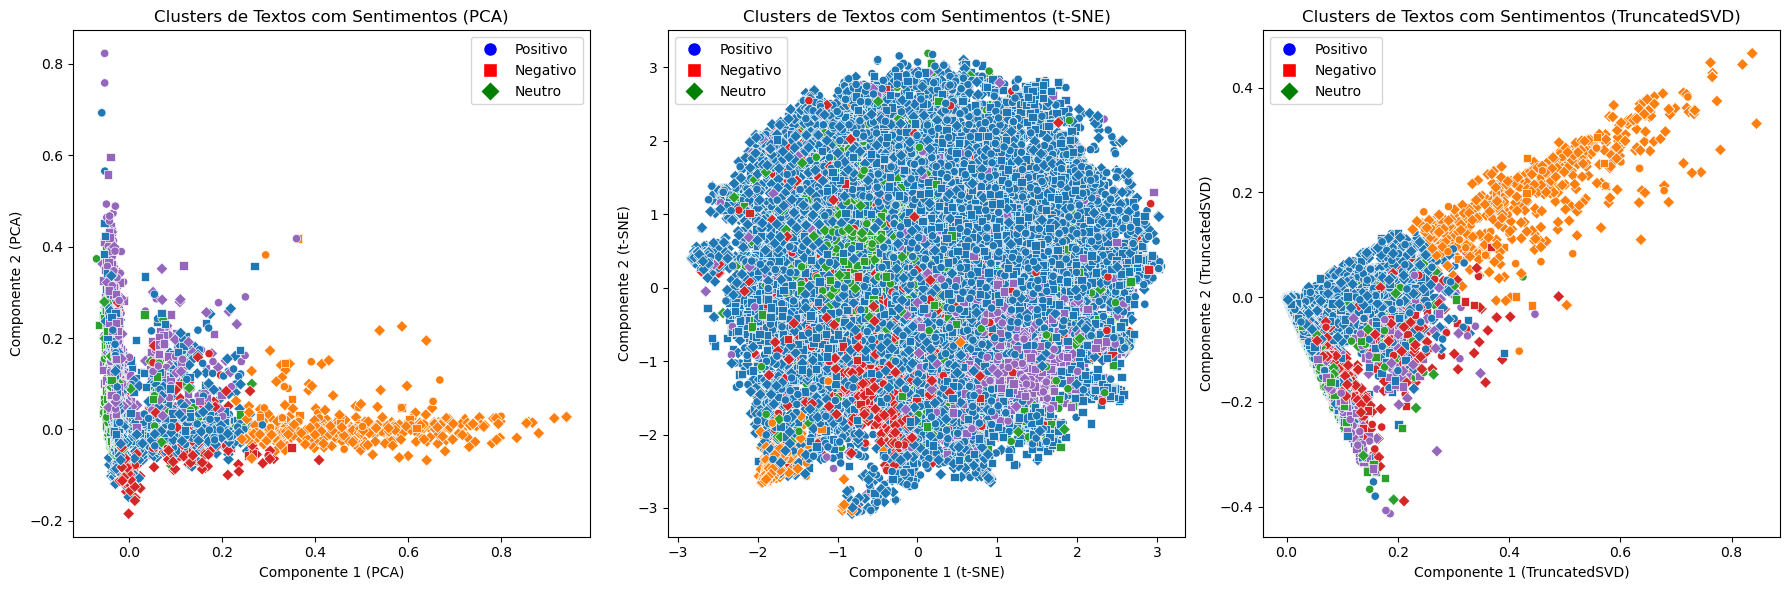

In [79]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D

# Função para criar legendas personalizadas
def create_custom_legend(labels, colors, markers, title):
    custom_legend = []
    for label, color, marker in zip(labels, colors, markers):
        custom_legend.append(Line2D([0], [0], marker=marker, color='w', label=label, markerfacecolor=color, markersize=10))
    return custom_legend

# Lista de cores e marcadores para cada sentimento
colors_sentimentos = {'positivo': 'blue', 'negativo': 'red', 'neutro': 'green'}
markers_sentimentos = {'positivo': 'o', 'negativo': 's', 'neutro': 'D'}

# Plotar os clusters com cores diferentes para cada sentimento usando PCA, t-SNE e TruncatedSVD
plt.figure(figsize=(18, 6))

# Plotar os clusters usando PCA
plt.subplot(1, 3, 1)
sns.scatterplot(x=X_pca[:, 0],
                y=X_pca[:, 1],
                hue=df['cluster'],
                style=df['sentiment'],
                palette='tab10',  # Usando uma paleta padrão com 10 cores diferentes
                markers=['o', 's', 'D'],  # Definindo marcadores padrão
                legend='full')
plt.title('Clusters de Textos com Sentimentos (PCA)')
plt.xlabel('Componente 1 (PCA)')
plt.ylabel('Componente 2 (PCA)')
plt.legend(handles=create_custom_legend(legendas_sentimentos.values(), colors_sentimentos.values(), markers_sentimentos.values(), 'Sentimento'))

# Plotar os clusters usando t-SNE
plt.subplot(1, 3, 2)
sns.scatterplot(x=X_tsne[:, 0],
                y=X_tsne[:, 1],
                hue=df['cluster'],
                style=df['sentiment'],
                palette='tab10',
                markers=['o', 's', 'D'],
                legend='full')
plt.title('Clusters de Textos com Sentimentos (t-SNE)')
plt.xlabel('Componente 1 (t-SNE)')
plt.ylabel('Componente 2 (t-SNE)')
plt.legend(handles=create_custom_legend(legendas_sentimentos.values(), colors_sentimentos.values(), markers_sentimentos.values(), 'Sentimento'))

# Plotar os clusters usando TruncatedSVD
plt.subplot(1, 3, 3)
sns.scatterplot(x=X_tsne_Truncated_SVD[:, 0],
                y=X_tsne_Truncated_SVD[:, 1],
                hue=df['cluster'],
                style=df['sentiment'],
                palette='tab10',
                markers=['o', 's', 'D'],
                legend='full')
plt.title('Clusters de Textos com Sentimentos (TruncatedSVD)')
plt.xlabel('Componente 1 (TruncatedSVD)')
plt.ylabel('Componente 2 (TruncatedSVD)')
plt.legend(handles=create_custom_legend(legendas_sentimentos.values(), colors_sentimentos.values(), markers_sentimentos.values(), 'Sentimento'))
plt.tight_layout()

# Salvar as imagens
plt.savefig('clusters_pca_tsne_truncatedsvd.png')  # Nome do arquivo pode ser alterado conforme necessário

# Visualizar os gráficos
plt.show()

In [77]:
# Salvando dataset
df.to_csv('dataset_clusterizado.csv', index=False)

In [78]:
## Salvando modelo

# Importando biblioteca
import joblib

# Salvar o modelo KMeans em um arquivo
joblib.dump(kmeans, 'modelo_kmeans.pkl')

['modelo_kmeans.pkl']